In [2]:
import pandas as pd
import os

# load the datasets
taxi = pd.read_parquet("../data/landing/cleaned_data.parquet")
weather = pd.read_csv("../data/landing/nyc_weather_2022.csv")

# convert the 'DATE' column in the weather dataset to datetime format and extract just the date
weather["DATE"] = pd.to_datetime(weather["DATE"]).dt.date

# merge the two datasets by the matching date
data = pd.merge(taxi, weather, left_on="date", right_on="DATE", how="inner")

# save the merged dataset as a parquet file
data.to_parquet("../data/curated/data.parquet")

data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,bad_weather
0,1,2022-04-01 00:14:20,2022-04-01 00:28:57,1.0,7.20,1.0,N,138,42,3,...,USW00094728,2022-04-01,3.9,7.1,0.0,0.0,11.10,16.1,6.1,1
1,2,2022-04-01 00:40:02,2022-04-01 01:15:49,1.0,7.58,1.0,N,100,145,2,...,USW00094728,2022-04-01,3.9,7.1,0.0,0.0,11.10,16.1,6.1,1
2,1,2022-04-01 00:28:37,2022-04-01 00:47:48,1.0,8.10,1.0,N,75,138,1,...,USW00094728,2022-04-01,3.9,7.1,0.0,0.0,11.10,16.1,6.1,1
3,2,2022-04-01 00:58:42,2022-04-01 01:41:42,3.0,18.30,2.0,N,132,48,1,...,USW00094728,2022-04-01,3.9,7.1,0.0,0.0,11.10,16.1,6.1,1
4,1,2022-04-01 00:10:13,2022-04-01 00:37:01,1.0,11.20,1.0,N,138,48,1,...,USW00094728,2022-04-01,3.9,7.1,0.0,0.0,11.10,16.1,6.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816494,2,2022-01-31 23:04:46,2022-01-31 23:32:18,1.0,13.72,1.0,N,264,148,1,...,USW00094728,2022-01-31,1.7,0.0,0.0,150.0,-3.25,-0.5,-6.0,0
816495,1,2022-01-31 23:03:29,2022-01-31 23:25:57,1.0,9.30,1.0,N,138,238,1,...,USW00094728,2022-01-31,1.7,0.0,0.0,150.0,-3.25,-0.5,-6.0,0
816496,2,2022-01-31 23:18:04,2022-01-31 23:35:21,2.0,9.93,1.0,N,138,229,1,...,USW00094728,2022-01-31,1.7,0.0,0.0,150.0,-3.25,-0.5,-6.0,0
816497,2,2022-01-31 23:04:23,2022-01-31 23:38:29,1.0,20.84,2.0,N,132,140,1,...,USW00094728,2022-01-31,1.7,0.0,0.0,150.0,-3.25,-0.5,-6.0,0


In [3]:
data.shape

(816499, 34)

# Fare and tip amount per time of the day

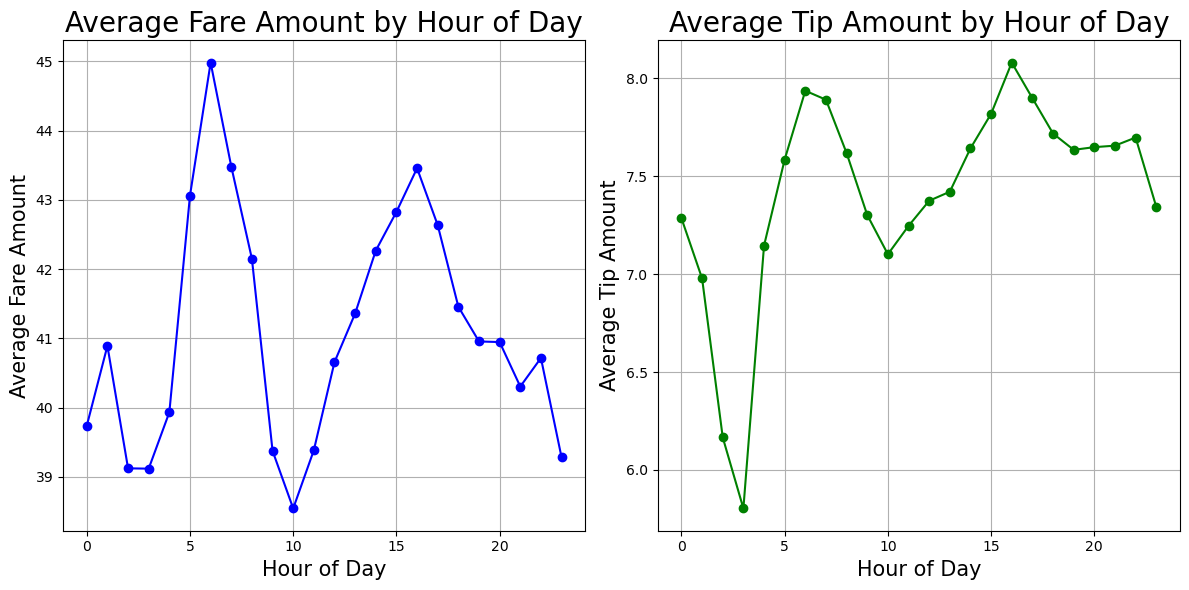

In [4]:
import matplotlib.pyplot as plt

# group by hour and compute average fare and tip amounts
grouped_data = data.groupby('hour').agg({
    'fare_amount': 'mean',
    'tip_amount': 'mean'
}).reset_index()

# visualization
plt.figure(figsize=(12, 6))

# plot for average fare amount by hour
plt.subplot(1, 2, 1)
plt.plot(grouped_data['hour'], grouped_data['fare_amount'], marker='o', color='blue')
plt.title('Average Fare Amount by Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Average Fare Amount', fontsize=15)
plt.grid(True)

# plot for average tip amount by hour
plt.subplot(1, 2, 2)
plt.plot(grouped_data['hour'], grouped_data['tip_amount'], marker='o', color='green')
plt.title('Average Tip Amount by Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Average Tip Amount', fontsize=15)
plt.grid(True)

plt.tight_layout()
plt.savefig('../plots/Avg amount by hour of day')
plt.show()

# Frequency of trips per time and day

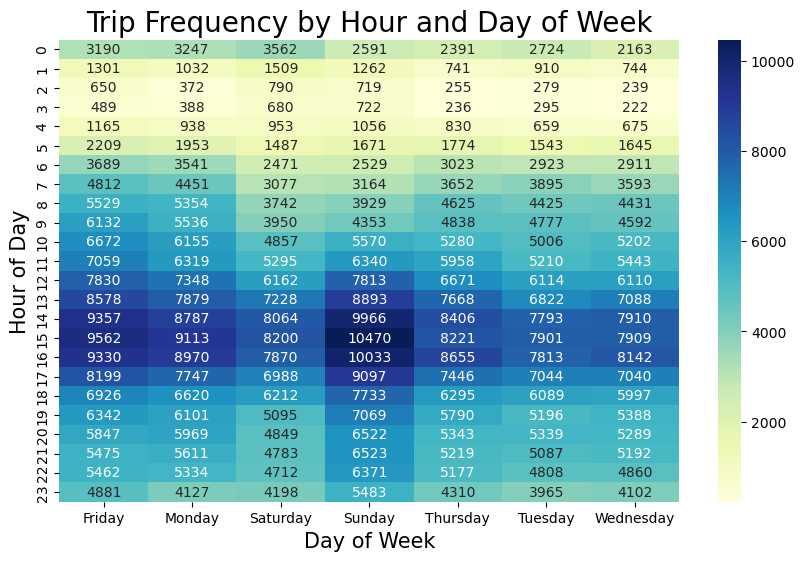

In [5]:
import seaborn as sns

# group by hour and day to count trips
trip_freq = data.groupby(['hour', 'day']).size().unstack().fillna(0)

# plot the frequncy per day and time
plt.figure(figsize=(10, 6))
sns.heatmap(trip_freq, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Trip Frequency by Hour and Day of Week', fontsize=20)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Hour of Day', fontsize=15)
plt.savefig('../plots/trip frequency by hour and day of week')

plt.show()

# Geographical visualisation

In [7]:
import geopandas as gpd

taxi_zones = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zone_lookup = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

# merge the taxi_zones with the zone_lookup to get the zone names
taxi_zones = taxi_zones.merge(zone_lookup, left_on='LocationID', right_on='LocationID')

# group by drop-off location and aggregate the total tips
tips_location = data.groupby('DOLocationID')['tip_amount'].sum().reset_index()

# merge the aggregated tips with the taxi_zones for visualization
most_tipped = taxi_zones.set_index('LocationID').join(tips_location.set_index('DOLocationID'))


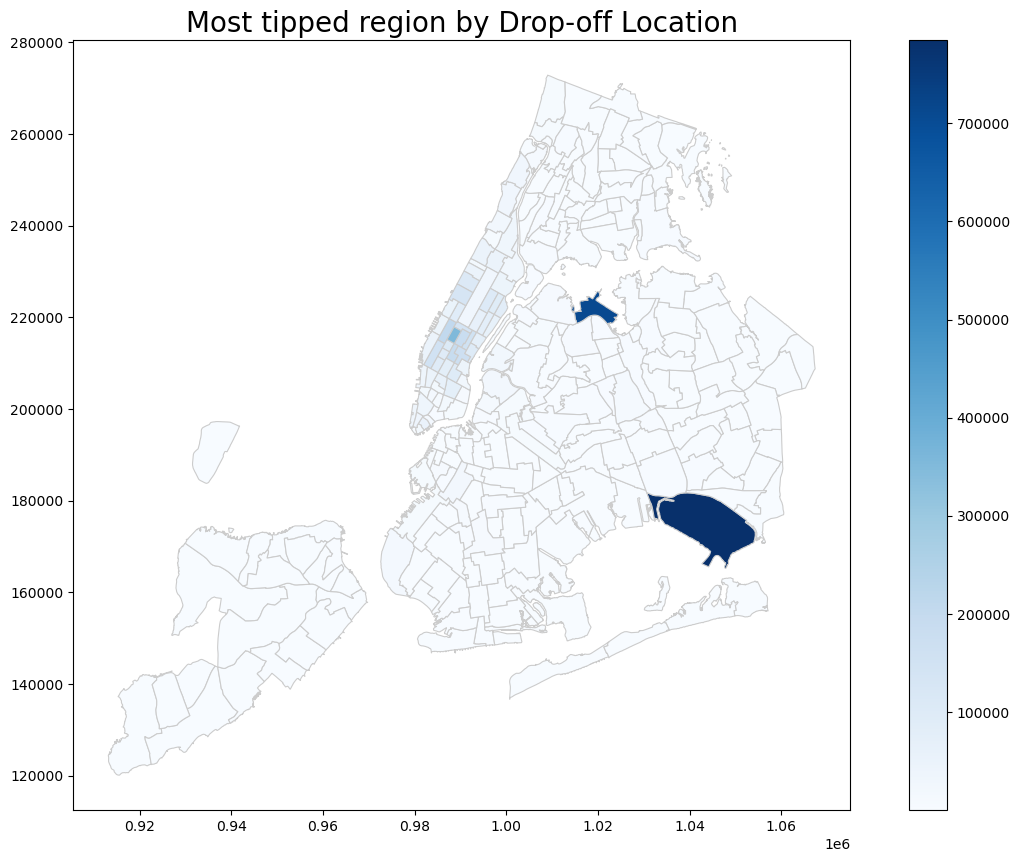

In [10]:
# plot heatmap showing the most tipped area by dropoff location
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
most_tipped.plot(column='tip_amount', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Most tipped region by Drop-off Location', fontsize=20)
plt.savefig('../plots/most tip by drop-off location')

plt.show()

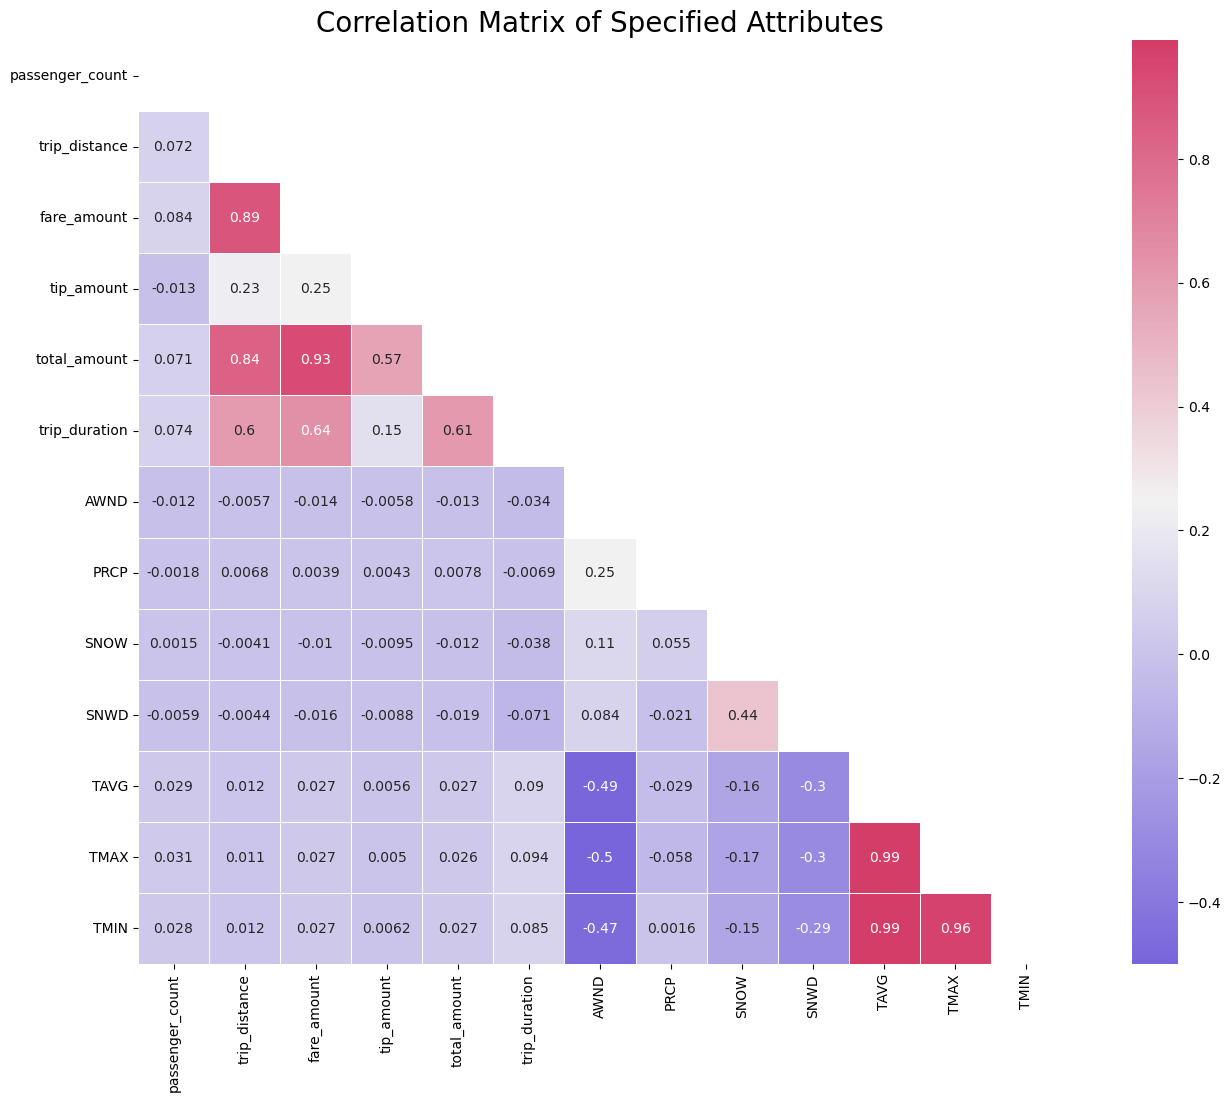

In [11]:
import numpy as np

# filter the dataset to only include the specified columns
relevant_columns = [
    'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 
    'trip_duration', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX','TMIN'
]
rel_data = data[relevant_columns]

# calculate the correlation matrix for the specified columns
correlation_matrix = rel_data.corr()

# only showing the half correlation matrix due to symmetry
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# generate a custom color
cmap = sns.diverging_palette(270, 0, as_cmap=True)

# visualize the correlation matrix using a heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, square=True, annot=True, linewidths=.5)
plt.title('Correlation Matrix of Specified Attributes', fontsize=20)
plt.savefig('../plots/correlation matrix')
plt.show()